In [3]:
!cv2 version

/bin/bash: cv2: command not found


In [80]:
!pip install split-folders tqdm

In [91]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

## Preprocessing the data

In [115]:
# init the initial learning rate, number of epochs to train for, and batch size
init_lr = 1e-4
epochs = 20
bs = 32
image_size = (224,224)

In [93]:
DIRECTORY = r"data"
CATEGORIES = ["with_mask","without_mask","mask_weared_incorrect"]

In [94]:
print("[INFO] loading images...")

[INFO] loading images...


In [95]:
# splitfolders.ratio('data',output='split_data', seed=1337, ratio=(.8,.1,.1))

## image_dataset_from_directory Pipeline

In [96]:
# create batch datasets

train_ds = image_dataset_from_directory('data',
                                       validation_split=0.2,
                                       subset='training',
                                       seed=1337,
                                       image_size=image_size,
                                       batch_size=bs)
test_ds = image_dataset_from_directory('data',
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=1337,
                                      image_size=image_size,
                                      batch_size=bs)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.
Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


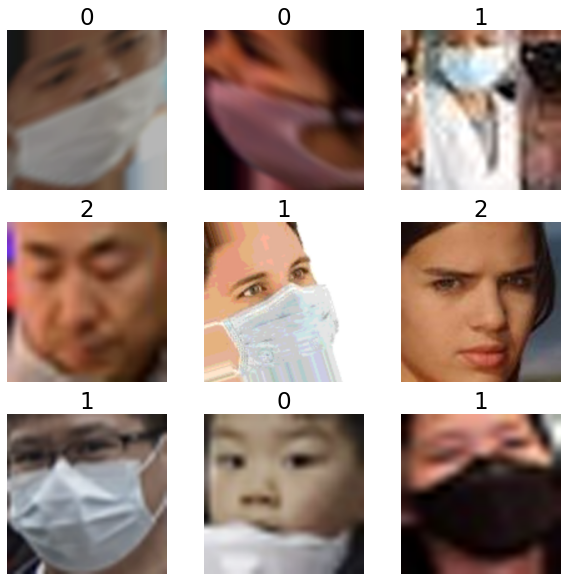

In [97]:
# visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## keras_generator Pipeline

In [98]:
# construct the training image generator for data augmentation
# recreating the images

aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [99]:
# for image_dataset_from_directory

# data_augmentation = keras.Sequential(
#     [
#         preprocessing.RandomFlip("horizontal"),
#         preprocessing.RandomRotation(0.1),
#         preprocessing.RandomHeight(0.2),
#         preprocessing.RandomWidth(0.2),
    
#     ]
# )

In [100]:
# train_ds = train_ds.prefetch(buffer_size=32)
# test_ds = test_ds.prefetch(buffer_size=32)

In [101]:
x_train, y_train = train.next()
x_test,y_test = test.next()
x_val, y_val = val.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (x_test.shape, x_test.min(), x_test.max()))
print(type(x_train))

Batch shape=(32, 224, 224, 3), min=0.000, max=255.000
<class 'numpy.ndarray'>


## Model building w/o function (hidden just in case)

In [102]:
# # load MobileNetV2 network, ensuring the head FC (Fully Connected) laery sets are left off
# inputs = Input(shape=(192,192,3))
# baseModel = MobileNetV2(input_shape=(192,192,3),weights="imagenet", include_top=False, input_tensor=inputs)

In [103]:
# # create the head of the model that will be placed on top of the base model
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(6,6))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(64, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)

In [104]:
# # place the head FC model on top of the base model (this will become the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)

# # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
# for layer in baseModel.layers:
#     layer.trainable=False

In [105]:
# # compile model
# print("[INFO] compiling model...")
# opt = Adam(lr=init_lr,decay=init_lr / epochs)
# model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [106]:
# # train head of the network
# print("[INFO] training head...")
# H = model.fit(
#         train,
#         steps_per_epoch=len(x_train[0]) // bs,
#         validation_data=val,
#         validation_steps=len(x_val[0]) //bs,
#         epochs=epochs,
#         callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=4,
#                                                   restore_best_weights=True)
# )

In [109]:
# train = datagen.flow_from_directory('split_data/train', class_mode='categorical',target_size=image_size, batch_size=bs)
# test = datagen.flow_from_directory('split_data/test',class_mode='categorical',target_size=image_size, batch_size=bs)
# val = datagen.flow_from_directory('split_data/val',class_mode='categorical',target_size=image_size, batch_size=bs)

# x_train, y_train = train.next()
# x_test,y_test = test.next()
# x_val, y_val = val.next()

# x_train[0].shape

## Model Building w/function

In [120]:
def build_model(num_classes, img_size=224):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(img_size,img_size,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [121]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)
    

In [122]:
train = datagen.flow_from_directory('split_data/train', class_mode='categorical',target_size=image_size, batch_size=bs)
test = datagen.flow_from_directory('split_data/val',class_mode='categorical',target_size=image_size, batch_size=bs)

Found 7185 images belonging to 3 classes.
Found 897 images belonging to 3 classes.


In [123]:
x_train, y_train = next(train)
x_test,y_test = next(test)

In [127]:
num_classes = len(CATEGORIES)
model = build_model(num_classes)

# train head of the network
print("[INFO] training head...")
H = model.fit(
        train,
        steps_per_epoch=len(train) // bs,
        validation_data=(x_test, y_test),
        validation_steps=len(x_test) // bs,
        batch_size=bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=4,
                                                  restore_best_weights=True)
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
7/7 [==============================] - 7s 779ms/step - loss: 1.4703 - accuracy: 0.4462 - val_loss: 1.0916 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 5s 715ms/step - loss: 1.4582 - accuracy: 0.3544 - val_loss: 0.9736 - val_accuracy: 0.5625
Epoch 3/20
7/7 [==============================] - 5s 740ms/step - loss: 1.3863 - accuracy: 0.3243 - val_loss: 0.9257 - val_accuracy: 0.6250
Epoch 4/20


KeyboardInterrupt: 

In [49]:
x_test.shape

(32, 256, 256, 3)

In [78]:
ev = model.evaluate(val, batch_size=bs)

29/29 [==============================] - 18s 595ms/step - loss: 0.5626 - accuracy: 0.7748


1st try: loss 0.6 accuracy .75 <br>
2nd try: loss 0.59 accuracy .77 <br>
3rd try: loss 0.57 accuracy .77

In [79]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=bs)

[INFO] evaluating network...


In [80]:
# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# ! DO CLASSIFICATION REPORT

In [84]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs, target_names=['Mask','No Mask','Mask Worn Incorrectly']))

                       precision    recall  f1-score   support

                 Mask       0.83      1.00      0.91        10
              No Mask       0.80      0.73      0.76        11
Mask Worn Incorrectly       0.90      0.82      0.86        11

             accuracy                           0.84        32
            macro avg       0.84      0.85      0.84        32
         weighted avg       0.84      0.84      0.84        32



In [63]:
# serialize the model to disk
print('[INFO] saving mask detector model...')
model.save("mask_detector.model", save_format='h5')

[INFO] saving mask detector model...


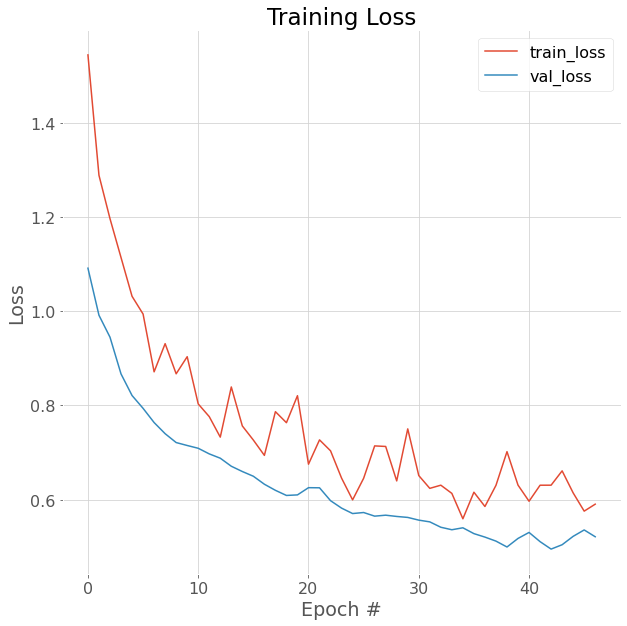

In [81]:
# plot the training loss and accuracy

plt.figure(figsize=(10,10))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')

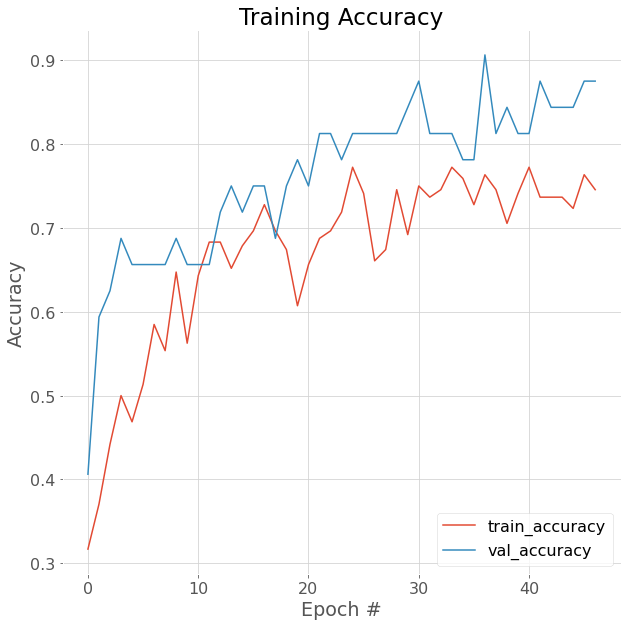

In [82]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='train_accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')

plt.title('Training Accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')